# Optimal control

This tutorial will be more comprehensive than the others, bringing together all of `cleo`'s main capabilities&mdash;electrode recording, optogenetics, and latency modeling&mdash;as well as introducing more sophisticated model-based optimal feedback control.
To achieve the latter, we will use the Python bindings to the [`ldsCtrlEst` C++ library](https://cloctools.github.io/lds-ctrl-est/).

First some boilerplate:

In [ ]:
from brian2 import ms, mm, um, second, mV, Hz, np
import brian2.only as b2
import matplotlib.pyplot as plt
import cleo

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = "numpy"
np.random.seed(17320222)
b2.seed(17870917)
cleo.utilities.set_seed(17991214)

cy1 = "#C500CC"
cy2 = "#df87e1"
cu1 = cleo.utilities.wavelength_to_rgb(463 * b2.nmeter)
cu2 = cleo.utilities.wavelength_to_rgb(483 * b2.nmeter)

## Network setup

For the network model we adapt an E/I network implementation [from the Neuronal Dynamics textbook](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network).
Let's run it and plot the spiking output:

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


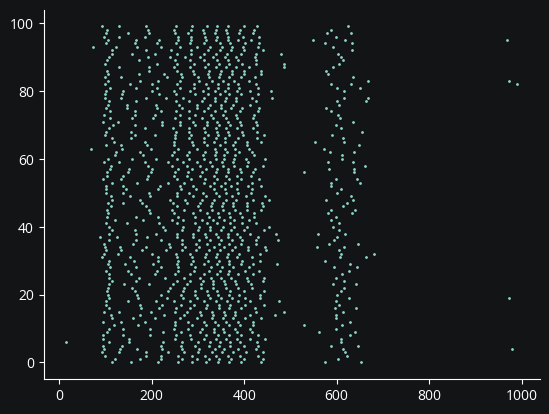

In [ ]:
b2.defaultclock.dt = 0.5 * b2.ms

n_exc = 80
n_inh = int(n_exc / 4)
connection_probability = 0.1
n_ext = int(n_exc * connection_probability)
w0 = 0.1 * b2.mV  # 0.2
g = 4
w_inh = -g * w0
synaptic_delay = 1.5 * b2.ms
w_external = w0
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
tau_m = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
thresh_rate = (firing_threshold - v_rest) / (w_external * n_ext * tau_m)
poisson_input_rate = 1 * thresh_rate
bias_current = 11 * b2.pA

bias_ng = b2.NeuronGroup(
    1, "dI_bias/dt = -I_bias / second + bias_current*xi/sqrt(tau_m) : amp"
)

lif_dynamics = """
dv/dt = (-(v-v_rest) + Rm * (I + I_bias)) / tau_m : volt (unless refractory)
I : amp
I_bias : amp (linked)
"""

ng = b2.NeuronGroup(
    n_exc + n_inh,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
ng.I_bias = b2.linked_var(bias_ng, "I_bias")

# random v init
ng.v = (
    np.random.uniform(
        v_rest / b2.mV, high=firing_threshold / b2.mV, size=(n_exc + n_inh)
    )
    * b2.mV
)
ng_exc = ng[:n_exc]
ng_inh = ng[n_exc:]

syn = b2.Synapses(
    ng,
    model="w : volt",
    on_pre="v += w",
    delay=synaptic_delay,
)
syn.connect(p=connection_probability)
syn[f"i < {n_exc}"].w = w0
syn[f"i >= {n_exc}"].w = w_inh

external_poisson_input = b2.PoissonInput(
    target=ng,
    target_var="v",
    N=n_ext,
    rate=poisson_input_rate,
    weight=w_external,
)

rate_monitor = b2.PopulationRateMonitor(ng)
spike_monitor = b2.SpikeMonitor(ng, record=True)

net = b2.Network(
    ng,
    bias_ng,
    syn,
    external_poisson_input,
    rate_monitor,
    spike_monitor,
)

runtime = 1 * b2.second
net.store()
net.run(runtime)

plt.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=1)
net.restore()

The spiking looks like we want: relatively stable with random fluctuations in global activity from the bias current we added.
This will make things more interesting for the controller.

## Coordinates, stimulation, and recording

Here we assign coordinates to the neurons and configure the optogenetic intervention and recording setup:

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

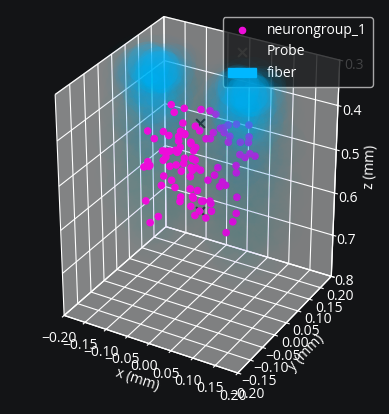

In [ ]:
hor_lim = 0.1
cleo.coords.assign_coords_rand_rect_prism(
    ng, xlim=(-hor_lim, hor_lim), ylim=(-hor_lim, hor_lim), zlim=(0.4, 0.6)
)

fibers = cleo.light.Light(
    name="fiber",
    light_model=cleo.light.fiber473nm(R0=50 * um),
    coords=[(-0.1, 0, 0.3), (0.1, 0, 0.3)] * mm,
)

opsin = cleo.opto.chr2_4s()

spikes = cleo.ephys.SortedSpiking(name="spikes")
probe = cleo.ephys.Probe(
    coords=[[0, 0, 0.4], [0, 0, 0.6]] * mm,
    signals=[spikes],
    save_history=True,
)

cleo.viz.plot(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.2, 0.2),
    ylim=(-0.2, 0.2),
    zlim=(0.3, 0.8),
    devices=[probe, fibers],
    scatterargs={"alpha": 1},
    axis_scale_unit=mm,
)

Looks right. Let's set up the simulation and inject the devices:

In [ ]:
sim = cleo.CLSimulator(net)
sim.inject(fibers, ng)
sim.inject(opsin, ng, Iopto_var_name="I")
sim.inject(probe, ng)
assert spikes.n_sorted >= 2

## Collect training data
Our goal will be to control two neuron's firing rates simultaneously.
To do this, we will use the LQR technique explained in [Bolus et al., 2021 ("State-space optimal feedback control of optogenetically driven neural activity)"](https://iopscience.iop.org/article/10.1088/1741-2552/abb89c/meta).
LQR is a model-based technique, and to fit a model of the system's dynamics, we first need training data.
We will generate training data using Gaussian random walk inputs, modulo'ed to a normal stimulation range (0-50 mW/mm²).
Here we structure our data into trials, as `ldsCtrlEst` is designed for.
$u$ represents the input and $z$ the spike output.

In [ ]:
n_trials = 5
n_samp = 500
u = []
z = []
n_u = 2  # 1-dimensional input (just one optogenetic actuator)
n_z = 2  # we'll be controlling two neurons
for trial in range(n_trials):
    u_trial = 10 * np.cumsum(np.random.randn(n_u, n_samp), axis=1) % 50
    u.append(u_trial)
    z.append(np.zeros((n_z, n_samp)))
# add some zeros to get right baseline
u[-1][:, (n_samp // 2) :] = 0

We configure the {class}`~cleo.ioproc.LatencyIOProcessor` to deliver our pre-computed stimulus and record the results, resetting after each trial:

In [ ]:
class TrainingStimIOP(cleo.LatencyIOProcessor):
    i_samp = 0
    i_trial = 0

    # here we just feed in the training inputs and record the outputs
    def process(self, state_dict, t_samp):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z[self.i_trial][:, self.i_samp] = z_t[:n_z]  # just first two neurons
        out = {"fiber": u[self.i_trial][:, self.i_samp] * b2.mwatt / b2.mm2}
        self.i_samp += 1
        return out, t_samp

    # gets called with sim.reset()
    def reset(self):
        self.i_samp = 0


dt = 5 * ms
training_stim_iop = TrainingStimIOP(sample_period=dt)
sim.set_io_processor(training_stim_iop)

for i_trial in range(n_trials):
    training_stim_iop.i_trial = i_trial
    sim.run(n_samp * dt)
    sim.reset()

INFO       No numerical integration method specified for group 'syn_ChR2_neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


WARNING    'dt' is an internal variable of group 'syn_ChR2_neurongroup_1', but also exists in the run namespace with the value 5. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:575: RuntimeWarning: overflow encountered in exp
  collision_prob_fn: Callable[[Quantity], float] = lambda t: 0.2 * np.exp(
 [py.warnings]


WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:446: RuntimeWarning: invalid value encountered in multiply
  collision_prob = self.collision_prob_fn(t_diff) * same_chan
 [py.warnings]


WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:450: RuntimeWarning: invalid value encountered in multiply
  collision_prob *= t_diff >= 0
 [py.warnings]


Let's plot our training data:

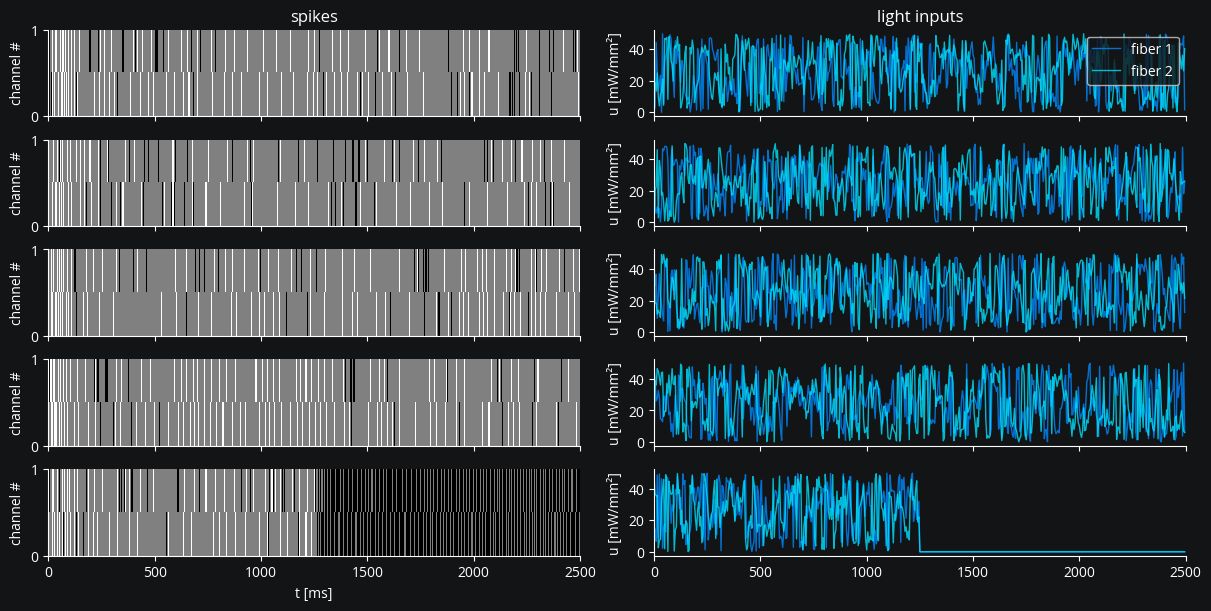

In [ ]:
fig, axs = plt.subplots(
    n_trials, 2, figsize=(12, 6), layout="compressed", sharex=True, sharey="col"
)

for i, (utrial, ztrial) in enumerate(zip(u, z)):
    # Plot spiking data
    ax_spike = axs[i, 0]
    ax_spike.imshow(
        ztrial,
        aspect="auto",
        cmap="gray",
        extent=[0, (n_samp * dt) / ms, *np.arange(n_z + 1)],
        interpolation="nearest",
        zorder=0,
    )
    ax_spike.set(ylabel="channel #", yticks=range(n_z))
    if i == n_trials - 1:
        ax_spike.set(xlabel="t [ms]")

    # Plot input data
    ax_input = axs[i, 1]
    lines = ax_input.plot(
        np.arange(n_samp) * dt / ms,
        utrial.T,
        alpha=0.8,
        lw=1,
    )
    for i, ln, c in zip(range(n_u), lines, [cu1, cu2]):
        ln.set(color=c, label=f"fiber {i + 1}")
    ax_input.set(ylabel="u [mW/mm²]")
    if i == n_trials - 1:
        ax_input.set(xlabel="t [ms]")

axs[0, 1].legend()
axs[0, 0].set(title="spikes")
axs[0, 1].set(title="light inputs")
plt.show()

## Model fitting

Now we have `u` and `z` in the form we need for `ldsctrlest`'s fitting functions: `n_trial`-length lists of `n` by `n_samp` arrays. We will now fit Gaussian linear dynamical systems using the SSID algorithm. See [the documentation](https://cloctools.github.io/lds-ctrl-est/) for more detailed explanations.

In [ ]:
import ldsctrlest as lds
import ldsctrlest.gaussian as glds

n_x_fit = 3  # latent dimensionality of system
n_h = 100  # size of block Hankel data matrix
u_train = lds.UniformMatrixList(u, free_dim=2)
z_train = lds.UniformMatrixList(z, free_dim=2)
ssid = glds.FitSSID(n_x_fit, n_h, dt / second, u_train, z_train)
fit, sing_vals = ssid.Run(lds.SSIDWt.kMOESP)
fit_sys_ssid = glds.System(fit)

Here we plot the singular values of the data matrix—we should see a drop at or before our chosen model order if we have a decent fit.
We also visualize impulse responses: we should see increases in firing rate for each of the fibers:

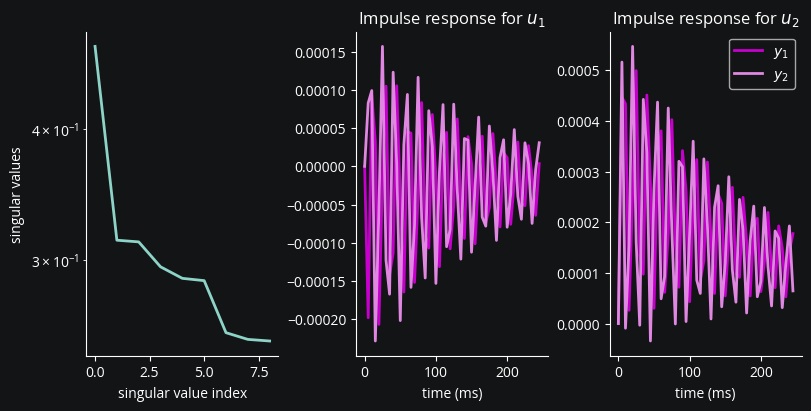

In [ ]:
n_samp_imp = 50
y_imp = fit_sys_ssid.simulate_imp(n_samp_imp)
t_imp = np.arange(n_samp_imp) * dt / ms

fig, axs = plt.subplots(1, 3, figsize=(2 + n_u * 3, 4), layout="compressed")
axs[0].semilogy(sing_vals[: n_x_fit * 3], linewidth=2)
axs[0].set(ylabel="singular values", xlabel="singular value index")

for i_u in range(n_u):
    ax = axs[i_u + 1]
    lines = ax.plot(t_imp, y_imp[i_u].T, linewidth=2)
    lines[0].set_color(cy1)
    lines[1].set_color(cy2)
    ax.set(title=f"Impulse response for $u_{i_u + 1}$", xlabel="time (ms)")


ax.legend(lines, ["$y_1$", "$y_2$"]);

We see a sharp drop in singular values after the first few, which justifies our model order choice.
For the impulse responses, we expect both fibers to cause transitory increases in firing rate for both electrodes.
Since we see that isn't the case for the first, let's try refining our fit with expectation-maximization (EM):

In [ ]:
em = glds.FitEM(fit, u_train, z_train)
fit_em = em.Run(
    calc_dynamics=True,
    calc_Q=True,
    calc_init=True,
    calc_output=True,
    calc_measurement=True,
    max_iter=50,
    tol=1e-2,
)
fit_sys_em = glds.System(fit_em)

We'll plot impulse responses again:

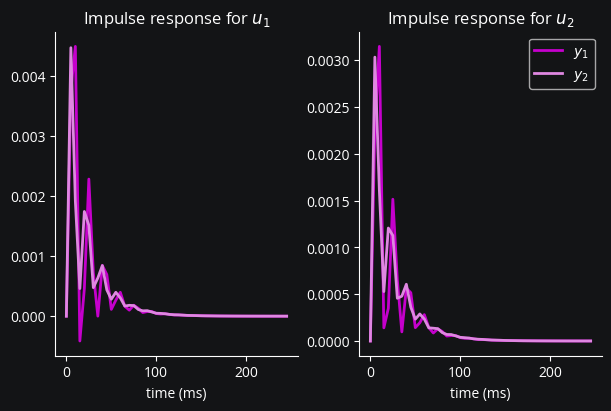

In [ ]:
y_imp = fit_sys_em.simulate_imp(n_samp_imp)

fig, axs = plt.subplots(1, 2, figsize=(3 * n_u, 4), layout="compressed")
for i_u in range(n_u):
    ax = axs[i_u]
    lines = ax.plot(t_imp, y_imp[i_u].T, linewidth=2)
    lines[0].set_color(cy1)
    lines[1].set_color(cy2)
    ax.set(title=f"Impulse response for $u_{i_u + 1}$", xlabel="time (ms)")

ax.legend(lines, ["$y_1$", "$y_2$"]);

Looking better.
Since we can't visualize singular values, let's compare the two fits with percent explained variance: 

In [ ]:
z_arr = np.array(z)


def pct_exp_var(sys, nstep=1):
    x_filt, x_pred, y_pred = sys.nstep_pred_block(u_train, z_train, nstep)
    y_pred = np.array(y_pred)
    assert y_pred.shape == z_arr[:, :, nstep:].shape, y_pred.shape
    corrcoef_mat = np.corrcoef(z_arr[:, :, nstep:].flatten(), y_pred[:, :, :].flatten())
    return corrcoef_mat[0, 1] ** 2


print("SSID r²:", pct_exp_var(fit_sys_ssid))
print("EM r²:", pct_exp_var(fit_sys_em))

SSID r²: 0.102694638612446
EM r²: 0.25244417523762247


As we suspected from the impulse responses, the EM-refined fit is much better.

## LQR optimal controller design

We now use the fit parameters to create the controller system and set additional parameters. The feedback gain, $ K_c $, is especially important, determining how the controller responds to the current "error"&mdash;the difference between where the system is (estimated to be) now and where we want it to be. The field of optimal control deals with how to design the controller so as to minimize a cost function reflecting what we care about.

With a linear system (obtained from the fitting procedure above) and quadratic per-timestep cost function $J$ penalizing distance from the reference $x^*$ and the input $u$

$$ L = \frac{1}{2} (x - x^*)^T Q (x - x^*) + \frac{1}{2} u^T R u $$

we can use the closed-form optimal solution called the Linear Quadratic Regulator (LQR).

$$ K = (R + B^T P B)^{-1}(B^T P A) \quad\quad u = -Kx$$

The $P$ matrix is obtained by numerically solving the discrete algebraic Riccati equation:

$$
P=A^{T} P A-\left(A^{T} P B\right)\left(R+B^{T} P B\right)^{-1}\left(B^{T} P A\right)+Q
$$

In [ ]:
# upper and lower bounds on control signal (optic fiber light intensity)
u_lb = 0  # mW/mm2
u_ub = 75  # mW/mm2
controller = glds.Controller(fit_sys_em, u_lb, u_ub)
# careful not to use this anymore since controller made a copy
del fit_sys_em

In [ ]:
from scipy.linalg import solve_discrete_are

A, B, C = controller.sys.A, controller.sys.B, controller.sys.C
# cost matrices
# Q reflects how much we care about state error
# we use C'C since we really care about output error, not latent state
Q_cost = C.T @ C
R_cost = 1e-4 * np.eye(n_u)  # reflects how much we care about minimizing the stimulus
P = solve_discrete_are(A, B, Q_cost, R_cost)
controller.Kc = np.linalg.inv(R_cost + B.T @ P @ B) @ (B.T @ P @ A)
print(controller)
print("For controlled system dynamics A - BK:")
print("eigvals:", np.linalg.eigvals(A - B @ controller.Kc))
print("magnitude of eigvals:", np.abs(np.linalg.eigvals(A - B @ controller.Kc)))


 ********** SYSTEM ********** 
x: 
   0.4597
  -0.3707
   0.0107

P: 
   0.2494   0.0093  -0.0009
   0.0093   0.2275   0.0009
  -0.0009   0.0009   0.2273

A: 
   0.8591   0.1965  -0.1724
  -0.1612  -0.0261   0.6788
  -0.0443  -0.8133  -0.3910

B: 
  -0.0160  -0.0136
  -0.0204  -0.0107
  -0.0063  -0.0063

g: 
   1.0000
   1.0000

m: 
        0
        0
        0

Q: 
   0.0646   0.0884   0.0294
   0.0884   0.1297   0.0482
   0.0294   0.0482   0.0460

Q_m: 
   1.0000e-06            0            0
            0   1.0000e-06            0
            0            0   1.0000e-06

d: 
   0.3933
   0.4164

C: 
  -0.1250  -0.1215   0.1148
  -0.1251  -0.1163  -0.0152

y: 
   0.3821
   0.4018

R: 
   0.1323  -0.0003
  -0.0003   0.1310

g_design :    1.0000
   1.0000

u_lb : 0
u_ub : 75

For controlled system dynamics A - BK:
eigvals: [ 0.60642864+0.j         -0.1935436 +0.59759058j -0.1935436 -0.59759058j]
magnitude of eigvals: [0.60642864 0.62815095 0.62815095]


We now configure a {class}`~cleo.ioproc.LatencyIOProcessor` to use our controller:

In [ ]:
y_ref = np.mean(z) * 0.75  # target rate per timebin


class CtrlLoop(cleo.LatencyIOProcessor):
    def __init__(self, sample_period, controller):
        super().__init__(sample_period)
        self.controller = controller
        self.sys = controller.sys
        self.do_control = False  # allows us to turn on and off control

        # for post hoc visualization/analysis:
        self.x_hat = np.empty((n_x_fit, 0))
        self.y_hat = np.empty((n_z, 0))
        self.z = np.empty((n_z, 0))

    def process(self, state_dict, t_samp):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z_t = z_t[:n_z].reshape((-1, 1))  # just first n_z neurons
        self.controller.y_ref = np.ones((n_z, 1)) * y_ref

        u_t = self.controller.ControlOutputReference(z_t, do_control=self.do_control)
        out = {fibers.name: u_t.squeeze() * b2.mwatt / b2.mm2}

        # record variables from this timestep
        self.y_hat = np.hstack([self.y_hat, self.sys.y])
        self.x_hat = np.hstack([self.x_hat, self.sys.x])
        self.z = np.hstack((self.z, z_t))

        return out, t_samp + 3 * ms  # 3 ms delay


ctrl_loop = CtrlLoop(sample_period=dt, controller=controller)

## Run the experiment

We'll now run the simulation with and without control to compare.

In [ ]:
sim.reset()  # only needed when rerunning
sim.set_io_processor(ctrl_loop)
T0 = 200 * ms
sim.run(T0)

ctrl_loop.do_control = True
T1 = 1000 * ms
sim.run(T1)

Now we plot the results to see how well the controller was able to match the desired firing rate:

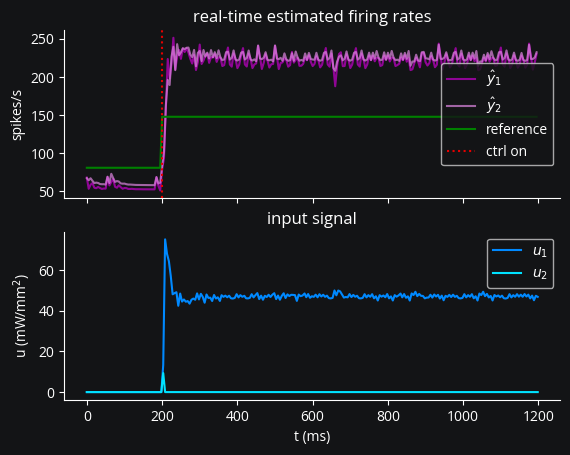

In [ ]:
def y_ref_fn(t, in_hertz=True):
    y_baseline = np.mean(controller.sys.d)
    if in_hertz:
        yr = y_ref / dt / Hz
        y_baseline /= dt * Hz
    else:
        yr = y_ref
    return y_baseline * (t < T0) + yr * (t >= T0)  # target rate per timebin


def plot_ctrl(loop):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set(ylabel="spikes/s", title="real-time estimated firing rates")
    ax1.plot(
        loop.t_samp / ms,
        loop.y_hat[0] / dt,
        c=cy1,
        alpha=0.7,
        label="$\\hat{y}_1$",
    )
    ax1.plot(
        loop.t_samp / ms,
        loop.y_hat[1] / dt,
        c=cy2,
        alpha=0.7,
        label="$\\hat{y}_2$",
    )
    ax1.plot(loop.t_samp / ms, y_ref_fn(loop.t_samp), c="green", label="reference")
    ax1.axvline(T0 / ms, c="xkcd:red", linestyle=":", label="ctrl on")
    ax1.legend(loc="right")
    ax2.plot(fibers.t / b2.ms, fibers.irradiance_[:, 0], c=cu1, label="$u_1$")
    ax2.plot(fibers.t / b2.ms, fibers.irradiance_[:, 1], c=cu2, label="$u_2$")
    ax2.legend()
    ax2.set(xlabel="t (ms)", ylabel="u (mW/mm$^2$)", title="input signal")


plot_ctrl(ctrl_loop)

What gives?
Why does the controller keep the input on when it's clearly over the target?
Let's check a Gaussian-smoothed post hoc estimated firing rate to confirm the firing rates are too high:

Results (spikes/second):
baseline = [10.  5.] Hz
target = 147.72 Hz
achieved = [222. 249.] Hz


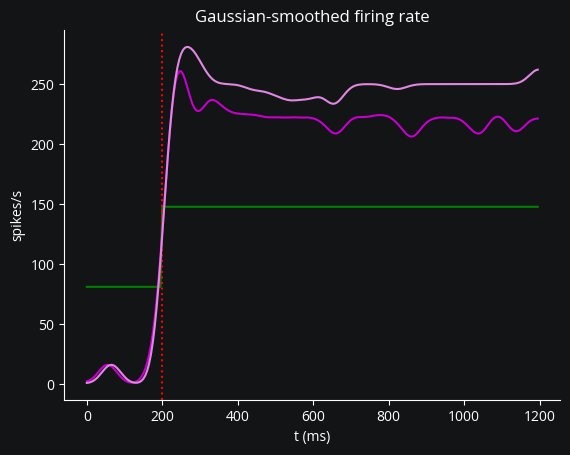

In [ ]:
from scipy.ndimage import gaussian_filter1d


def plot_post_hoc(loop):
    i_baseline = loop.t_samp < T0
    i_static = (loop.t_samp >= T0) & (loop.t_samp < T0 + T1)
    print("Results (spikes/second):")
    print("baseline =", np.sum(loop.z[:, i_baseline], axis=1) / T0)
    print("target =", y_ref / dt)
    print(
        "achieved =",
        (np.sum(loop.z[:, i_static], axis=1) / T1).round(1),
    )

    win_len = 25 * ms / dt
    smoothed = gaussian_filter1d(loop.z, sigma=win_len, axis=1) / dt
    plt.plot(loop.t_samp / ms, y_ref_fn(loop.t_samp), c="green", label="reference")
    plt.axvline(T0 / ms, c="r", ls=":")
    plt.xlabel("t (ms)")
    plt.ylabel("spikes/s")
    plt.title("Gaussian-smoothed firing rate")
    plt.plot(loop.t_samp / ms, smoothed[0], c=cy1)
    plt.plot(loop.t_samp / ms, smoothed[1], c=cy2)


plot_post_hoc(ctrl_loop)

And so they are.
Another possibility is that the steady-state set point calculated by the controller is unattainable.
Let's see:

In [ ]:
controller.u_ref

array([[ 66.30858641],
       [-58.64187695]])

It looks to be the case.
The controller kept $u_1$ high since what it was trying to use negative $u_2$ at the same time—unfortunately, we can't exactly use negative light.
Even if the controller didn't fail in this way, its ignorance of the upper limit (75 mW/mm²) poses another problem.
This is a fundamental limitation of LQR; it can't account for constraints.
What's the solution?


## Accounting for input constraints

Let's help out LQR by computing a set point that respects our constraints.
We need to break out convex optimization tools to do so though.

In [ ]:
import cvxpy as cp


def opt_u_x():
    """
    Solve the optimal control problem using CVXPY.
    """
    # Define the optimization variables
    u = cp.Variable(n_u)
    x = cp.Variable(n_x_fit)
    y_r = np.full(n_z, y_ref)

    # Define the cost function
    cost = cp.sum_squares(C @ x + controller.sys.d - y_r) + cp.quad_form(u, R_cost)

    # Define the constraints
    constraints = [
        x == A @ x + B @ u,
        u >= u_lb,
        u <= u_ub,
    ]

    # Define the optimization problem
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    return u.value, x.value


u_ref, x_ref = opt_u_x()
u_ref, x_ref

WARNING    /home/kyle/miniforge3/envs/cleo/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
 [py.warnings]


(array([13.63429967, 10.11708157]),
 array([-2.49125289, -0.00271575, -0.02609246]))

That `u_ref` looks much better!
Let's try again, this time using the `Control` method of the controller, that lets us set the `x` and `u` reference values ourselves, rather than computing the unhelpful values we saw.

In [ ]:
class CtrlLoop2(cleo.LatencyIOProcessor):
    def __init__(self, sample_period, controller):
        super().__init__(sample_period)
        self.controller = controller
        self.sys = controller.sys
        self.do_control = False  # allows us to turn on and off control

        # for post hoc visualization/analysis:
        self.x_hat = np.empty((n_x_fit, 0))
        self.y_hat = np.empty((n_z, 0))
        self.z = np.empty((n_z, 0))

    def process(self, state_dict, t_samp):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z_t = z_t[:n_z].reshape((-1, 1))  # just first n_z neurons

        self.controller.u_ref = u_ref
        self.controller.x_ref = x_ref
        u_t = self.controller.Control(z_t, do_control=self.do_control)
        if not self.do_control:
            u_t = np.zeros((n_u, 1))  # no control
        out = {fibers.name: u_t.squeeze() * b2.mwatt / b2.mm2}

        # record variables from this timestep
        self.y_hat = np.hstack([self.y_hat, self.sys.y])
        self.x_hat = np.hstack([self.x_hat, self.sys.x])
        self.z = np.hstack((self.z, z_t))

        return out, t_samp + 3 * ms  # 3 ms delay


ctrl_loop2 = CtrlLoop2(sample_period=dt, controller=controller)


In [ ]:
sim.reset()
sim.set_io_processor(ctrl_loop2)
sim.run(T0)

ctrl_loop2.do_control = True
sim.run(T1)

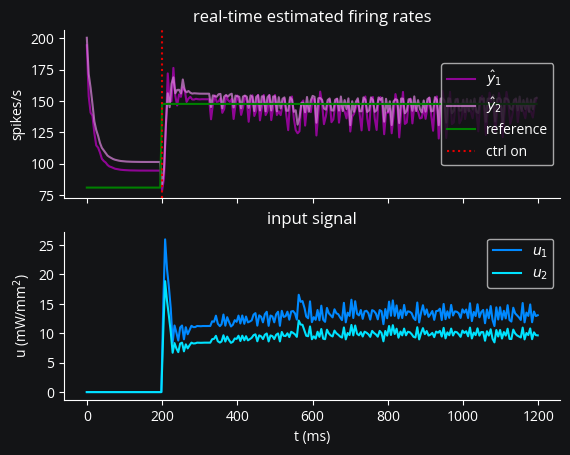

In [ ]:
plot_ctrl(ctrl_loop2)

Results (spikes/second):
baseline = [0. 0.] Hz
target = 147.72 Hz
achieved = [156. 165.] Hz


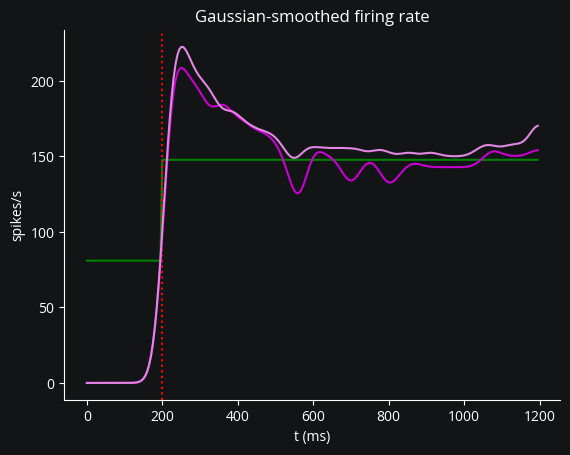

In [ ]:
plot_post_hoc(ctrl_loop2)

There we go!
That looks much better.

## Conclusion
As a recap, in this tutorial we've seen how to:
- inject optogenetic stimulation into an existing Brian network
- inject an electrode into an existing Brian network to record spikes
- generate training data and fit a Gaussian linear dynamical system to the spiking output using `ldsctrlest`
- configure an `ldsctrlest` LQR controller based on that linear system and design optimal gains
- use that controller in running a complete simulated feedback control experiment
- work around the limitations of LQR by computing a feasible setpoint using convex optimization

## Bonus: model predictive control
The stage is now set for model predictive control (MPC), which, by solving an optimization problem at every timestep, has two important capabilities LQR does not:

1. It can look ahead, optimizing a time-varying control trajectory over a horizon of specified length.
2. It can account for linear constraints on states and inputs.

The main downside is the increased computational cost compared to LQR.

Let's try this experiment again with MPC instead, using the [`lqmpc` package](https://github.com/CLOCTools/lqmpc).

### MPC setup

In [ ]:
import lqmpc

H = 20
mpc = lqmpc.LQMPC(dt / second, A, B, C)
# N, M are prediction and control horizons
mpc.set_control(Q_cost, R_cost, N=H, M=H - 1)
mpc.set_constraints(umin=np.zeros(n_u), umax=np.full(n_u, u_ub))

Since MPC runs a quadratic program under the hood every timestep, one advantage we should have is not needing to think about the optimal setpoints like we just did.
However, `lqmpc` only support a state, not output reference, so we'll just use the same reference value for now.
Adding MPC to `ldsctrlest` is planned, including control by output reference; when implemented, this tutorial should be updated.

In [ ]:
# lqmpc doesn't support directly optimizing y_ref, so we use the same steady-state x_ref
def xref_fn(t):
    return (t >= T0) * x_ref[:, None]

We mentioned a downside of MPC was the increased computational cost.
Let's measure how long the controller takes:

In [ ]:
mpc.simulate(
    t_sim=dt / second,
    x0=np.zeros(n_x_fit),
    u0=u_ref,
    xr=xref_fn(np.arange(200) * dt),
    L=150,
);

Simulation Time: 0.20595026 s 
Mean Step Time: 0.001373 s 



Roughly 3 ms.
Good to know!
Let's increase the latency of our control loop from 3 to 6 ms then.
Unlike `ldsCtrlEst`, `lqmpc` does not have built-in Kalman filtering, so we'll need to add that too:

In [ ]:
class MPCLoop(cleo.LatencyIOProcessor):
    def __init__(self, sample_period):
        super().__init__(sample_period)
        # for post hoc visualization/analysis:
        self.x_hat = np.empty((n_x_fit, 0))
        self.y_hat = np.empty((n_z, 0))
        self.z = np.empty((n_z, 0))

        mpc.xi = np.zeros(n_x_fit)
        mpc.ui = u_ref
        self.P_cov = controller.sys.P  # initialize state covariance matrix
        self.Q = controller.sys.Q
        self.R = controller.sys.R
        self.d = controller.sys.d.squeeze()

    def process(self, state_dict, t_samp):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z_t = z_t[:n_z]  # just first n_z neurons

        # update state covariance for Kalman filtering
        # predict step
        P_pred = A @ self.P_cov @ A.T + self.Q
        # Kalman gain
        S = C @ P_pred @ C.T + self.R
        K = P_pred @ C.T @ np.linalg.inv(S)
        # Update step
        z_err = z_t - (C @ mpc.xi + self.d)  # Measurement residual
        mpc.xi = mpc.xi + K @ z_err
        self.P_cov = (np.eye(len(P_pred)) - K @ C) @ P_pred
        x_hat = mpc.xi.copy()

        mpc.step(
            dt / second, mpc.xi, mpc.ui, xref_fn(t_samp + np.arange(H) * dt), out=False
        )
        u_t = mpc.ui

        out = {fibers.name: u_t.squeeze() * b2.mwatt / b2.mm2}

        # record variables from this timestep
        y_hat = C @ x_hat + self.d
        self.y_hat = np.column_stack([self.y_hat, y_hat])
        self.x_hat = np.column_stack([self.x_hat, x_hat])
        self.z = np.column_stack((self.z, z_t))

        return out, t_samp + 6 * ms


mpc_loop = MPCLoop(sample_period=dt)

### Rerunning the experiment

In [ ]:
sim.reset()
sim.set_io_processor(mpc_loop)
sim.run(T0 + T1)

WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/light/light.py:557: UserWarning: fiber: negative light value clipped to 0
  warnings.warn(f"{self.name}: negative light value clipped to 0")
 [py.warnings]


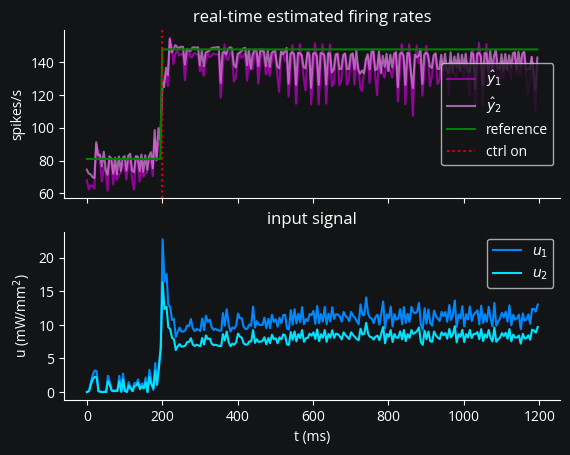

In [ ]:
plot_ctrl(mpc_loop)

Results (spikes/second):
baseline = [55. 60.] Hz
target = 147.72 Hz
achieved = [154. 160.] Hz


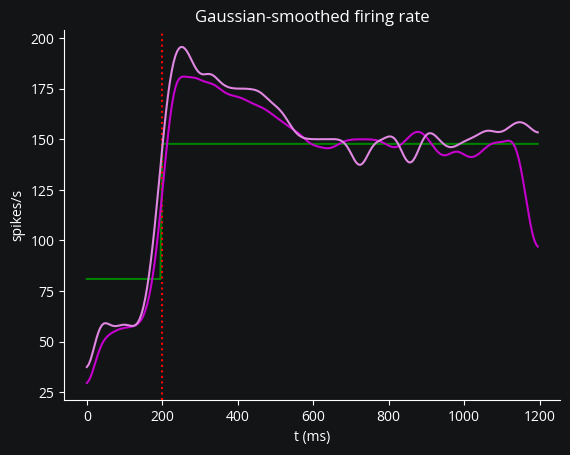

In [ ]:
plot_post_hoc(mpc_loop)

Also looking good.
We don't see much of an advantage over LQR with a constraint-informed setpoint here since the optimization we performed was most of what was needed for a static reference.
This essentially did part of MPC's job for it; the difference being that MPC optimizes an entire trajectory (over a receding horizon), ensuring constraints are met at every step.
We do see less overshoot though, which makes sense since our controller is looking 100 ms ahead.

This should be revisited with a time-varying reference once `ldsctrlest`'s MPC with output reference control is available.